This project will use the aggregated and scaled data from the KMeans and KMetoids full data set 
in DBSCAN and compare the results of these three common clustering methods
Importing all packages even if not needed since full effort will need them

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import itertools
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import silhouette_score 
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D


Set float to 2 places and show all columns
Import and check the test dataframe

In [ ]:
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.max_columns', 999)

In [ ]:
filepath = ('agg_log_trans_only_2009.csv')
df = pd.read_csv(filepath)

print("The shape of the df is", df.shape)

Scale the previously transformed data

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

Create new data frame with scaled data

In [ ]:
df_dbs = pd.DataFrame(scaled_data, index=df.index,
                      columns=['MonetaryValue','Frequency', 'Recency'])
print('The shape of df_dbs is:', df_dbs.shape)

Create new df for X to convert into numpy for plotting

In [ ]:
X_df = df_dbs.copy()
X = X_df.to_numpy()
print('Shape of X is:', X.shape)

Use k-NN to calulate distances in the dataset

In [ ]:
# Compute the k-nearest neighbors distances
k = 5  # Number of neighbors
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Sort distances and plot
distances = np.sort(distances[:, k-1])  # Fixed indexing error
plt.plot(distances)
plt.title('k-NN Distance Plot')
plt.xlabel('Data Points')
plt.ylabel('k-NN Distance')
plt.show()

Use prepared functions to calculate best epsilon

In [ ]:
best_score = -1
best_epsilon = None

for percentile in [0.80, 0.85, 0.90, 0.95]:
    epsilon = distances[round(len(distances) * percentile)]
    db = DBSCAN(eps=epsilon, min_samples=k).fit(X)
    labels = db.labels_
    if len(set(labels)) > 1:  # Avoid single cluster case
        score = silhouette_score(X, labels)
        if score > best_score:
            best_score = score
            best_epsilon = epsilon

print("Best epsilon:", best_epsilon)
print("Best Silhouette Score:", best_score)

Calculated best epsilon is 0.4

Calulate best min_samples

In [ ]:
min_samples_values = [5, 10, 15, 20]
best_score = -1
best_params = None

for min_samples in min_samples_values:
    db = DBSCAN(eps=best_epsilon, min_samples=min_samples).fit(X)
    labels = db.labels_
    if len(set(labels)) > 1:
        score = silhouette_score(X, labels)
        if score > best_score:
            best_score = score
            best_params = (best_epsilon, min_samples)

print("Best params (epsilon, min_samples):", best_params)
print("Best Silhouette Score:", best_score)


calculated best min_samples is 15

Apply DBSCAN to the data

In [ ]:
db = DBSCAN(eps=.4, min_samples=15).fit(X)
labels = db.labels_
print('The shape of X is:', X.shape)
print('The shape of labels is:', labels.shape)

Plot the result

In [ ]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap='viridis')  # Plotting the data points
ax.set_title('DBSCAN Clustering Result')
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.show()


DBSCAN identifies outliers as 'noise' and excludes them.
Plot the 'noise' in black

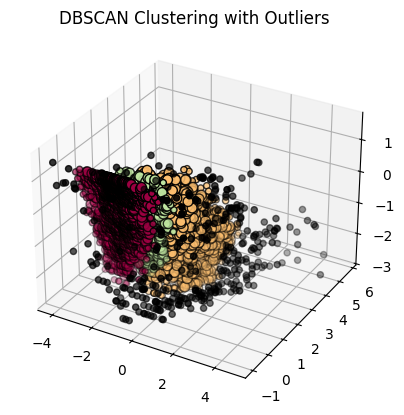

In [25]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xyz = X[class_member_mask & core_samples_mask]
    ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=[col], edgecolor='k', s=50)

    xyz = X[class_member_mask & ~core_samples_mask]
    ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=[col], edgecolor='k', s=20)

ax.set_title('DBSCAN Clustering with Outliers')
plt.show()
